In [1]:
from numpy import ndarray
import numpy as np
from scipy.sparse import vstack, identity, spmatrix
from typing import Optional, cast, Union
from scipy.linalg import eigh
from scipy.sparse.linalg import eigsh
from scipy.stats import pearsonr
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from joblib import Parallel, delayed
from functools import partial



def _ged_wong(
    Z: ndarray,
    D: Optional[ndarray] = None,
    P: Optional[ndarray] = None,
    n_components=1,
    method="type1",
):
    if method != "type1" and method != "type2":
        raise ValueError("not supported method type")

    A = Z
    if D is not None:
        A = D.T @ A
    if P is not None:
        A = P.T @ A
    A = A.T @ A
    if method == "type1":
        B = Z
        if D is not None:
            B = D.T @ Z
        B = B.T @ B
        if isinstance(A, spmatrix) or isinstance(B, spmatrix):
            D, W = eigsh(A, k=n_components, M=B)
        else:
            D, W = eigh(A, B)
    elif method == "type2":
        if isinstance(A, spmatrix):
            D, W = eigsh(A, k=n_components)
        else:
            D, W = eigh(A)

    D_exist = cast(ndarray, D)
    ind = np.argsort(D_exist)[::-1]
    D_exist, W = D_exist[ind], W[:, ind]
    return D_exist[:n_components], W[:, :n_components]


def _trca_kernel(X: ndarray):
    """TRCA.
    X: (n_trials, n_channels, n_samples)
    """
    X = np.reshape(X, (-1, *X.shape[-2:]))
    M, C, N = X.shape
    n_components = C
    P = vstack([identity(N) for _ in range(M)])
    P = P @ P.T
    Z = np.hstack(X).T  # type: ignore
    _, U = _ged_wong(Z, None, P, n_components=n_components)  # U for X
    return U


def _trca_feature(
    X: ndarray,
    templates: ndarray,
    Us: ndarray,
    n_components: int = 1,
    ensemble: bool = True,
):
    rhos = []
    if not ensemble:
        for Xk, U in zip(templates, Us):
            a = U[:, :n_components].T @ X
            b = U[:, :n_components].T @ Xk
            a = np.reshape(a, (-1))
            b = np.reshape(b, (-1))
            rhos.append(pearsonr(a, b)[0])
    else:
        U = Us[:, :, :n_components]
        U = np.concatenate(U, axis=-1)
        for Xk in templates:
            a = U.T @ X
            b = U.T @ Xk
            a = np.reshape(a, (-1))
            b = np.reshape(b, (-1))
            rhos.append(pearsonr(a, b)[0])
    return rhos


class TRCA(BaseEstimator, TransformerMixin, ClassifierMixin):
    def __init__(
        self, n_components: int = 1, ensemble: bool = True, n_jobs: Optional[int] = None
    ):
        self.n_components = n_components
        self.ensemble = ensemble
        self.n_jobs = n_jobs

    def fit(self, X: ndarray, y: ndarray, Yf: Optional[ndarray] = None):
        self.classes_ = np.unique(y)
        X = np.reshape(X, (-1, *X.shape[-2:]))
        X = X - np.mean(X, axis=-1, keepdims=True)
        self.templates_ = np.stack(
            [np.mean(X[y == label], axis=0) for label in self.classes_]
        )

        self.Us_ = np.stack([_trca_kernel(X[y == label]) for label in self.classes_])
        return self

    def transform(self, X: ndarray):
        X = np.reshape(X, (-1, *X.shape[-2:]))
        X = X - np.mean(X, axis=-1, keepdims=True)
        n_components = self.n_components
        templates = self.templates_
        Us = self.Us_
        ensemble = self.ensemble
        rhos = Parallel(n_jobs=self.n_jobs)(
            delayed(
                partial(
                    _trca_feature, Us=Us, n_components=n_components, ensemble=ensemble
                )
            )(a, templates)
            for a in X
        )
        rhos = np.stack(rhos)
        return rhos

    def predict(self, X: ndarray):
        feat = self.transform(X)
        labels = self.classes_[np.argmax(feat, axis=-1)]
        return labels


def generate_cca_references(
    freqs,
    srate,
    T,
    phases: Optional[Union[ndarray, int, float]] = None,
    n_harmonics: int = 1,
):
    if isinstance(freqs, int) or isinstance(freqs, float):
        freqs = [freqs]
    freqs = np.array(freqs)[:, np.newaxis]
    if phases is None:
        phases = 0
    if isinstance(phases, int) or isinstance(phases, float):
        phases = np.array([phases])
    phases = np.array(phases)[:, np.newaxis]
    t = np.linspace(0, T, int(T * srate))

    Yf = []
    for i in range(n_harmonics):
        Yf.append(
            np.stack(
                [
                    np.sin(2 * np.pi * (i + 1) * freqs * t + np.pi * phases),
                    np.cos(2 * np.pi * (i + 1) * freqs * t + np.pi * phases),
                ],
                axis=1,
            )
        )
    Yf = np.concatenate(Yf, axis=1)
    return Yf

In [2]:
list_freqs = [8, 9, 10, 11, 12, 13, 14, 15, 8.2, 9.2, 10.2, 11.2, 12.2, 13.2, 14.2, 15.2, 8.4, 9.4, 10.4, 11.4, 12.4, 13.4, 14.4, 15.4, 8.6, 9.6, 10.6, 11.6, 12.6, 13.6, 14.6, 15.6, 8.8, 9.8, 10.8, 11.8, 12.8, 13.8, 14.8, 15.8]
list_phases = [0, 1.75, 1.50, 1.25, 1.0, 0.75, 0.50, 0.25, 0.35, 0.10, 1.85, 1.60, 1.35, 1.10, 0.85, 0.60, 0.70, 0.45, 0.20, 1.95, 1.70, 1.45, 1.20, 0.95, 1.05, 0.80, 0.55, 0.30, 0.05, 1.80, 1.55, 1.30, 1.40, 1.15, 0.90, 0.65, 0.40, 0.15, 1.90, 1.65]
char_map = {
  8: 'A',
  9: 'B',
  10: 'C',
  11: 'D',
  12: 'E',
  13: 'F',
  14: 'G',
  15: 'H',
  8.2: 'I',
  9.2: 'J',
  10.2: 'K',
  11.2: 'L',
  12.2: 'M',
  13.2: 'N',
  14.2: 'O',
  15.2: 'P',
  8.4: 'Q',
  9.4: 'R',
  10.4: 'S',
  11.4: 'T',
  12.4: 'U',
  13.4: 'V',
  14.4: 'W',
  15.4: 'X',
  8.6: 'Y',
  9.6: 'Z',
  10.6: '0',
  11.6: '1',
  12.6: '2',
  13.6: '3',
  14.6: '4',
  15.6: '5',
  8.8: '6',
  9.8: '7',
  10.8: '8',
  11.8: '9',
  12.8: ' ',
  13.8: ',',
  14.8: '.',
  15.8: '<-'
}

Opening raw data file sunsun.fif...
    Range : 0 ... 102805 =      0.000 ...   411.220 secs
Ready.
Creating RawArray with float64 data, n_channels=9, n_times=100556
    Range : 0 ... 100555 =      0.000 ...   402.220 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

220 events found


C:\Users\bci\AppData\Local\Temp\ipykernel_6084\223189090.py:4: RuntimeWarning: This filename (sunsun.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw =  mne.io.read_raw_fif(fname)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Event IDs: [1]
Not setting metadata
220 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 220 events and 676 original time points ...
1 bad epochs dropped
Effective window size : 1.024 (s)
Opening raw data file sunsun_v2.fif...
    Range : 0 ... 103950 =      0.000 ...   415.800 secs
Ready.
Creating RawArray with float64 data, n_channels=9, n_times=101701
    Range : 0 ... 101700 =      0.000 ...   406.800 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

223 events found
Event IDs: [1]
Not setting metadata
223 matching events found
No baseline correction applied
0 projection items activat

c:\Users\bci\.virtualenvs\hybrid-ssvep-p300-speller-ZL_XZSnA\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\bci\AppData\Local\Temp\ipykernel_6084\223189090.py:14: RuntimeWarning: This filename (sunsun_v2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_test =  mne.io.read_raw_fif(fname_test)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Do

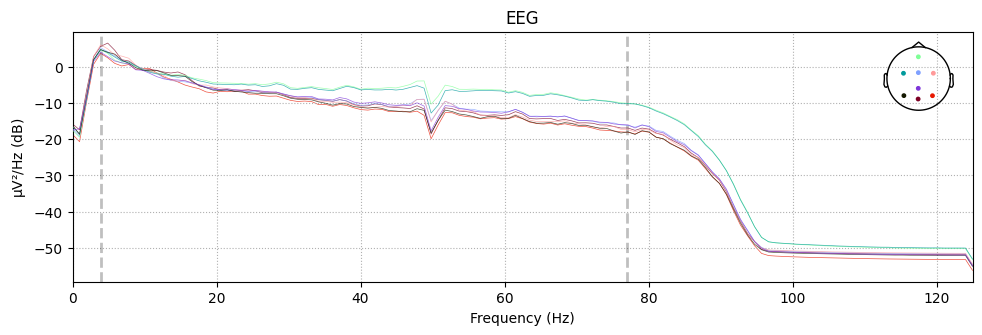

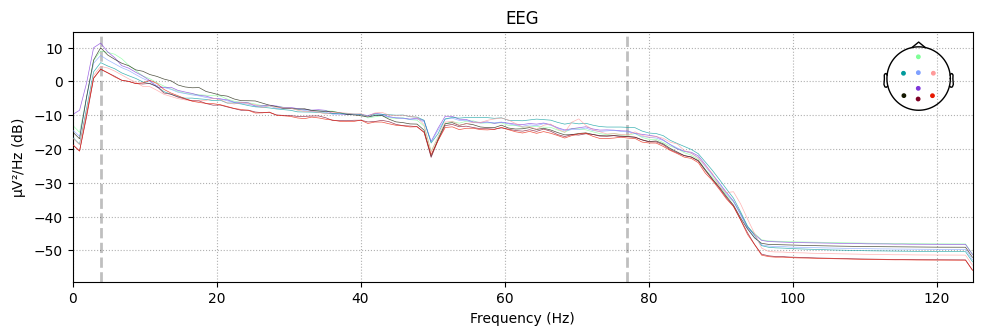

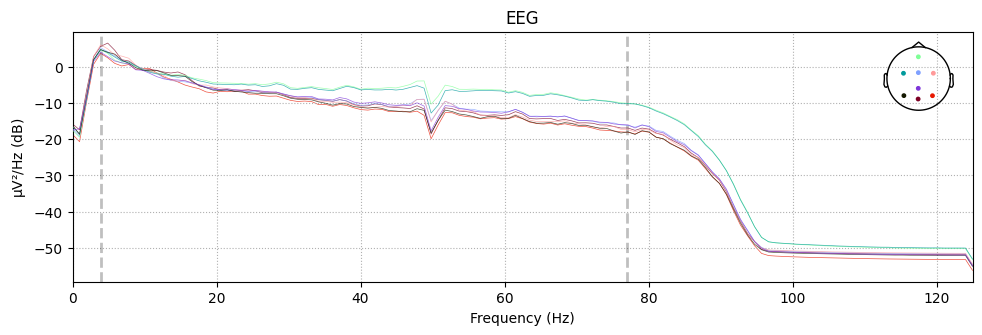

In [3]:
import mne

fname = "sunsun.fif"
raw =  mne.io.read_raw_fif(fname)
new_data = raw.get_data()[:,7*250:-2*250]
raw = mne.io.RawArray(new_data, raw.info)
raw.notch_filter([50,100])
events = mne.find_events(raw)
epochs = mne.Epochs(raw=raw,events=events, baseline=None, tmin=0, tmax=2.7, reject=None, reject_by_annotation=False)
data = epochs.get_data()
raw.compute_psd().plot()

fname_test = "sunsun_v2.fif"
raw_test =  mne.io.read_raw_fif(fname_test)
new_data = raw_test.get_data()[:,7*250:-2*250]
raw_test = mne.io.RawArray(new_data, raw.info)
raw_test.notch_filter([50,100])
events_test = mne.find_events(raw_test)
epochs_test = mne.Epochs(raw=raw_test,events=events_test, baseline=None, tmin=0, tmax=2.7, reject=None, reject_by_annotation=False)
data_test = epochs_test.get_data()
raw_test.compute_psd().plot()

In [4]:
amp = 1e-5
duration = int(250 * 0.5)
offset_1 = 150
offset_2 = 150 + duration

In [5]:
#Preparing data for the ensemble TRCA

samples = data[0][0].size - 1
print(samples)
eeg_ch = 8
# X = []
# f = 8
t = np.arange(0,1,1/samples)
# p = np.pi * 0
X_train = []
y_train = []

for index, (f , p) in enumerate(zip(list_freqs * 5, list_phases * 5)):
    p = np.pi * p
    X = []
    for ch_idx in range(eeg_ch):
        s = data[index][ch_idx][:-1]
        signal = s 
        for N in range(1,5):
            ssvep = ((amp * np.sin((2 * np.pi * N * f * t) + p))) * 1/N
            # signal[150:150+250] = signal[150:150+250] + ssvep[:250]
            signal[offset_1: offset_2] = signal[offset_1: offset_2] + ssvep[:duration]
        X.append(signal.reshape(1,-1))

    X = np.vstack(X)
    # plt.plot(X.T)
    # plt.show()  
    X_train.append(X)
    y_train.append(char_map[f])

X_train = np.dstack(X_train)
X_train = np.swapaxes(X_train, 0, 2)
X_train = np.swapaxes(X_train, 1, 2)
y_train = np.array(y_train)
print(y_train.shape)

675
(200,)


In [6]:
X_train.shape

(200, 8, 675)

In [7]:
y_train.shape

(200,)

In [8]:
samples = data_test[0][0].size - 1
print(samples)
eeg_ch = 8
# X = []
# f = 8
t = np.arange(0,1,1/samples)
# p = np.pi * 0
X_test = []
y_test = []

for index, (f , p) in enumerate(zip(list_freqs * 5, list_phases * 5)):
    p = np.pi * p
    X = []
    for ch_idx in range(eeg_ch):
        s = data_test[index][ch_idx][:-1]
        signal = s 
        for N in range(1,5):
            ssvep = ((amp * np.sin((2 * np.pi * N * f * t) + p))) * 1/N
            signal[offset_1: offset_2] = signal[offset_1: offset_2] + ssvep[:duration]
        X.append(signal.reshape(1,-1))

    X = np.vstack(X)
    # plt.plot(X.T)
    # plt.show()  
    X_test.append(X)
    y_test.append(char_map[f])

X_test = np.dstack(X_test)
X_test = np.swapaxes(X_test, 0, 2)
X_test = np.swapaxes(X_test, 1, 2)
y_test = np.array(y_test)
print(y_test.shape)

675
(200,)


In [12]:
from sklearn.utils import shuffle

Yf = generate_cca_references(freqs=list_freqs, srate=250, T=2.7, phases=list_phases, n_harmonics=5)
# for n in range(1,10):
estimator=TRCA(n_components = 1, n_jobs=-1)
# X_train, X_test, y_train, y_test = train_test_split(X_complete, y_complete, test_size=0.3)
model = estimator.fit(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)
preds = model.predict(X_test)
acc = np.mean(preds==y_test)
# print(preds)
# print(y_test)
print(acc)

0.915


In [10]:
import pickle

# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [11]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.915
